## Multi-Step Temporal Forecasts in Keras

#### MLP vs LSTM
MLPs require different shaped inputs than LSTMs. Data for MLPs is best in the shape (batch_size, features), whereas for an LSTM, the required input is (batch_size, time_lags, features).

In [4]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def reshape_time_series(X, lags = 30, horizon = 30, nn_type = 'mlp'):
    """
    Reshapes a univariate time series into a form appropriate for a Keras MLP.
    
    Also adds sinusoidal features based on time, which help the MLP to model
    seasonality.
    
    Args:
        X (np.ndarray): Univariate time series.
        lags (int): Lags per training sample.
        horizon (int): Forecast horizon
        
    Returns:
        Tuple containing reshaped X and y arrays.
    """
    
    num_samples = len(X) - lags - horizon
    X_processed = []
    y_processed = []
    
    for i in range(num_samples):
        
        X_slice = X[i:i+lags]
        y_slice = X[i+lags:i+lags+horizon]
        
        X_processed.append(X_slice)
        y_processed.append(y_slice)
        
    return np.array(X_processed), (y_processed)

In [6]:
horizon = 20
lags = 75

t = np.linspace(0,100, 1000)
X = np.sin(t)

X_processed, y_processed = reshape_time_series(X, lags = lags, horizon = horizon, period = 60*24)
print(np.shape(X_processed))
X_processed = np.array(X_processed.reshape((-1, lags, 1)))
y_processed = np.array(y_processed)
print(np.shape(X_processed))
print(np.shape(y_processed))

NameError: name 'reshape_time_series_MLP' is not defined

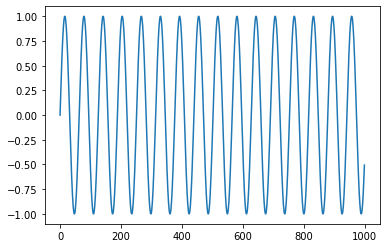

In [73]:
plt.plot(X)

In [7]:
num_samples = 5000
time_steps = 15
features = 1
batch_size = 128
epochs = 30

Text(0, 0.5, 'y')

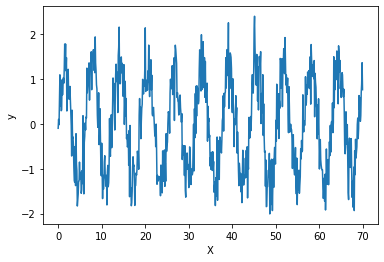

In [8]:
# Generate a time series
n = 1000
X = np.linspace(0,100, (n*features)).reshape((n, features))
y = np.sin(X) + np.random.normal(0,0.3, (n, features))

train_rows = int(len(X)*0.7)
val_rows = int(len(X)*0.2 + train_rows)

X_train = X[:train_rows]
X_val = X[train_rows:val_rows]
X_test = X[val_rows:]

y_train = y[:train_rows]
y_val = y[train_rows:val_rows]
y_test = y[val_rows:]

y_train = (y_train - np.mean(y_train))/(np.std(y_train))
y_val = (y_val - np.mean(y_train))/(np.std(y_train))
y_test = (y_test - np.mean(y_train))/(np.std(y_train))

plt.plot(X_train, y_train)
plt.xlabel("X")
plt.ylabel("y")

In [9]:
# Use Keras to create a generator with both time series sequences and their targets.
data_gen_train = TimeseriesGenerator(y_train, y_train,
                               length=time_steps, sampling_rate=1,
                               batch_size=batch_size)

data_gen_val = TimeseriesGenerator(y_val, y_val,
                               length=time_steps, sampling_rate=1,
                               batch_size=batch_size)

In [69]:
model = Sequential()
model.add(LSTM(units=30, return_sequences= True, input_shape=(lags,features)))
model.add(LSTM(units=30))
model.add(Dense(units=128))
model.add(Dropout(0.5))
model.add(Dense(units=horizon))

model.summary()

model.compile(optimizer='adam', loss='mean_squared_error')

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 75, 30)            3840      
_________________________________________________________________
lstm_13 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dense_12 (Dense)             (None, 128)               3968      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 20)                2580      
Total params: 17,708
Trainable params: 17,708
Non-trainable params: 0
_________________________________________________________________


In [70]:
#model.fit(X, Y, epochs=20, batch_size=32)

model.fit(X_processed, y_processed, epochs = epochs)

Train on 905 samples
Epoch 1/30
905/905 [==============================] - 5s 6ms/sample - loss: 0.3422
Epoch 2/30
905/905 [==============================] - 0s 490us/sample - loss: 0.0602s - loss:
Epoch 3/30
905/905 [==============================] - 0s 548us/sample - loss: 0.0357
Epoch 4/30
905/905 [==============================] - 0s 544us/sample - loss: 0.0289s - loss: 0
Epoch 5/30
905/905 [==============================] - 0s 541us/sample - loss: 0.0250
Epoch 6/30
905/905 [==============================] - 0s 514us/sample - loss: 0.0224s - loss:
Epoch 7/30
905/905 [==============================] - 0s 498us/sample - loss: 0.0205
Epoch 8/30
905/905 [==============================] - 0s 499us/sample - loss: 0.0194s - loss: 0.
Epoch 9/30
905/905 [==============================] - 0s 546us/sample - loss: 0.0178
Epoch 10/30
905/905 [==============================] - 0s 535us/sample - loss: 0.0162
Epoch 11/30
905/905 [==============================] - 0s 464us/sample - loss: 0.0152
Epo

In [71]:
y_preds = model.predict(X_processed)

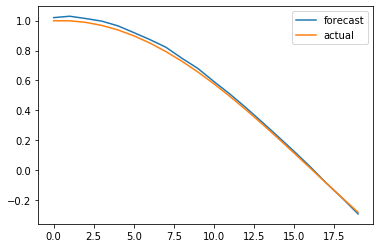

In [76]:
j = 3

plt.plot(y_preds[j], label = "forecast")
plt.plot(X[lags+j:lags+j+horizon], label = "actual")
plt.legend()

In [7]:
class time_series_generator:
    
    """
    Generates batches of time series data suitable for Keras.
    
    Keras requires time series data to be fed in with the format 
    (batch_size, time_lags, features). This generator automatically
    reshapes tabular data. It also adds sinusoidal waves to give the
    neural net some concepts of where in the period we are located,
    as neural networks do not model periodicity very well.
    
    Handles multivariable inputs and outputs.
    """
    
    def __init__(self, X, lags, horizon, batch_size = 32):
        
        "Initialise generator class."
        
        self.lags = lags
        self.horizon = horizon
        self.batch_size = batch_size
        self.X = X
 
    def flow(self, X):
        
        """
        Generates a list of input data and target data.
        
        The input data list contains the reshaped time series data
        and another dataset containing sinusoidal features.
        """
        
        while True:
        
            input_batch = []
            targets_batch = []
    
            for i in range(self.batch_size):
                # Need to start indexing from lags
                data_idx = np.random.randint(self.lags, len(X) - self.horizon)
    
                data_lags = X[data_idx - lags: data_idx]
                input_batch.append(data_lags)
            
                targets = X[data_idx:data_idx + self.horizon]
                targets_batch.append(targets) 

            
            input_batch = np.reshape(input_batch, (self.batch_size, self.lags, -1))
            targets_batch = np.reshape(targets_batch, (self.batch_size, -1))
    
            yield input_batch, targets_batch

In [8]:
date_gen = time_series_generator(X, lags, horizon)

In [9]:
model.fit_generator(date_gen.flow(X), steps_per_epoch = len(X)//32, epochs = 10)

NameError: name 'model' is not defined